In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from time import time

# Device and dtype
DTYPE = torch.float32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Domain bounds
pi = torch.tensor(np.pi, dtype=DTYPE, device=device)
tmin, tmax = 0., 4.
xmin, xmax = -np.pi, np.pi
lb = torch.tensor([tmin, xmin], dtype=DTYPE, device=device)
ub = torch.tensor([tmax, xmax], dtype=DTYPE, device=device)

# Initial conditions
def fun_u_0(x):
    return torch.sin(x)

def fun_v_0(x):
    return torch.sin(x)

# Boundary conditions (periodic)
def fun_u_b(t, x): return torch.zeros_like(x)
def fun_v_b(t, x): return torch.zeros_like(x)

# Sample sizes
N_0, N_b, N_r = 50, 100, 1000  # instead of 100, 240, 5000

# Initial points
t_0 = torch.full((N_0, 1), lb[0], device=device)
x_0 = (ub[1] - lb[1]) * torch.rand((N_0, 1), device=device) + lb[1]
X_0 = torch.cat([t_0, x_0], dim=1)
u_0 = fun_u_0(x_0)
v_0 = fun_v_0(x_0)

# Boundary points
t_b = (ub[0] - lb[0]) * torch.rand((N_b, 1), device=device) + lb[0]
x_b = torch.bernoulli(torch.full((N_b, 1), 0.5, device=device)) * (ub[1] - lb[1]) + lb[1]
X_b = torch.cat([t_b, x_b], dim=1)
u_b = fun_u_b(t_b, x_b)
v_b = fun_v_b(t_b, x_b)

# Collocation points
t_r = (ub[0] - lb[0]) * torch.rand((N_r, 1), device=device) + lb[0]
x_r = (ub[1] - lb[1]) * torch.rand((N_r, 1), device=device) + lb[1]
X_r = torch.cat([t_r, x_r], dim=1)

X_data = [X_0, X_b]
u_data = [u_0, u_b]
v_data = [v_0, v_b]

# Coupled PINN model
class CoupledPINN(nn.Module):
    def __init__(self, num_hidden_layers=8, num_neurons_per_layer=20):
        super(CoupledPINN, self).__init__()
        self.scaling = lambda x: 2.0 * (x - lb) / (ub - lb) - 1.0

        def build_network():
            layers = [nn.Linear(2, num_neurons_per_layer), nn.Tanh()]
            for _ in range(num_hidden_layers - 1):
                layers += [nn.Linear(num_neurons_per_layer, num_neurons_per_layer), nn.Tanh()]
            layers += [nn.Linear(num_neurons_per_layer, 1)]
            return nn.Sequential(*layers)

        self.net_u = build_network()
        self.net_v = build_network()

    def forward(self, x):
        x_scaled = self.scaling(x)
        return self.net_u(x_scaled), self.net_v(x_scaled)

# Exact solution
def exact_solution(x, t):
    return torch.exp(-t) * torch.sin(x)

# PDE residuals
def compute_residuals(model, X_r):
    X_r.requires_grad_(True)
    t = X_r[:, 0:1]
    x = X_r[:, 1:2]

    u, v = model(X_r)

    grads_u = torch.autograd.grad(u, X_r, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    grads_v = torch.autograd.grad(v, X_r, grad_outputs=torch.ones_like(v), create_graph=True)[0]

    u_t, u_x = grads_u[:, 0:1], grads_u[:, 1:2]
    v_t, v_x = grads_v[:, 0:1], grads_v[:, 1:2]

    u_xx = torch.autograd.grad(u_x, X_r, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 1:2]
    v_xx = torch.autograd.grad(v_x, X_r, grad_outputs=torch.ones_like(v_x), create_graph=True)[0][:, 1:2]

    uv = u * v
    uv_x = torch.autograd.grad(uv, X_r, grad_outputs=torch.ones_like(uv), create_graph=True)[0][:, 1:2]

    r1 = u_t - u_xx - 2 * u * u_x + uv_x
    r2 = v_t - v_xx - 2 * v * v_x + uv_x

    return r1, r2

# Loss function
def compute_loss(model, X_r, X_data, u_data, v_data):
    r1, r2 = compute_residuals(model, X_r)
    loss = torch.mean(r1**2) + torch.mean(r2**2)
    for i in range(len(X_data)):
        u_pred, v_pred = model(X_data[i])
        loss += torch.mean((u_data[i] - u_pred)**2)
        loss += torch.mean((v_data[i] - v_pred)**2)
    return loss

# Model, optimizer
model = CoupledPINN(num_hidden_layers=4, num_neurons_per_layer=10).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training
epochs = 2000
loss_history = []
L2_history = []
Linf_history = []
iterations = [100, 200, 500, 1000, 1500, 2000]  # We will track errors for these epochs

start_time = time()
for epoch in range(epochs + 1):
    optimizer.zero_grad()
    loss = compute_loss(model, X_r, X_data, u_data, v_data)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    
    if epoch in iterations:
        # Calculate L2 and L∞ errors
        u_pred, v_pred = model(X_r)
        u_exact = exact_solution(X_r[:, 1], X_r[:, 0])
        v_exact = exact_solution(X_r[:, 1], X_r[:, 0])
        
        # L∞ error
        L_inf_u = torch.max(torch.abs(u_pred - u_exact)).item()
        L_inf_v = torch.max(torch.abs(v_pred - v_exact)).item()
        L_inf = max(L_inf_u, L_inf_v)

        # L2 error (corrected)
        L2_u = torch.sqrt(torch.mean((u_pred - u_exact)**2))
        L2_v = torch.sqrt(torch.mean((v_pred - v_exact)**2))
        L2 = max(L2_u.item(), L2_v.item())  # Convert to scalar here

        L2_history.append(L2)
        Linf_history.append(L_inf)

    if epoch % 100 == 0:
        print(f"Epoch {epoch:05d}: Loss = {loss.item():.6e}")

print("Training time:", time() - start_time)

# Create table of errors for different epochs
import pandas as pd

error_table = pd.DataFrame({
    'Epoch': iterations,
    'L2 Error': L2_history,
    'L∞ Error': Linf_history
})

print(error_table)


Epoch 00000: Loss = 1.385142e+00
Epoch 00100: Loss = 7.730823e-01
Epoch 00200: Loss = 5.855911e-01
Epoch 00300: Loss = 3.391641e-01
Epoch 00400: Loss = 1.046573e-01
Epoch 00500: Loss = 3.181148e-02
Epoch 00600: Loss = 1.704889e-02
Epoch 00700: Loss = 9.577008e-03
Epoch 00800: Loss = 6.041189e-03
Epoch 00900: Loss = 4.239011e-03
Epoch 01000: Loss = 3.242065e-03
Epoch 01100: Loss = 2.628577e-03
Epoch 01200: Loss = 2.256976e-03
Epoch 01300: Loss = 1.875956e-03
Epoch 01400: Loss = 1.624133e-03
Epoch 01500: Loss = 1.421086e-03
Epoch 01600: Loss = 1.259138e-03
Epoch 01700: Loss = 1.145599e-03
Epoch 01800: Loss = 1.015572e-03
Epoch 01900: Loss = 9.225474e-04
Epoch 02000: Loss = 8.469070e-04
Training time: 139.35272645950317
   Epoch  L2 Error  L∞ Error
0    100  0.291355  1.283964
1    200  0.303223  1.395932
2    500  0.369846  1.875394
3   1000  0.347762  1.900171
4   1500  0.346420  1.893639
5   2000  0.345785  1.893116


In [8]:
# Define grid for plotting
N_plot = 100
t_vals = torch.linspace(tmin, tmax, N_plot, device=device)
x_vals = torch.linspace(xmin, xmax, N_plot, device=device)
T, X = torch.meshgrid(t_vals, x_vals, indexing='ij')
TX = torch.cat([T.reshape(-1, 1), X.reshape(-1, 1)], dim=1)


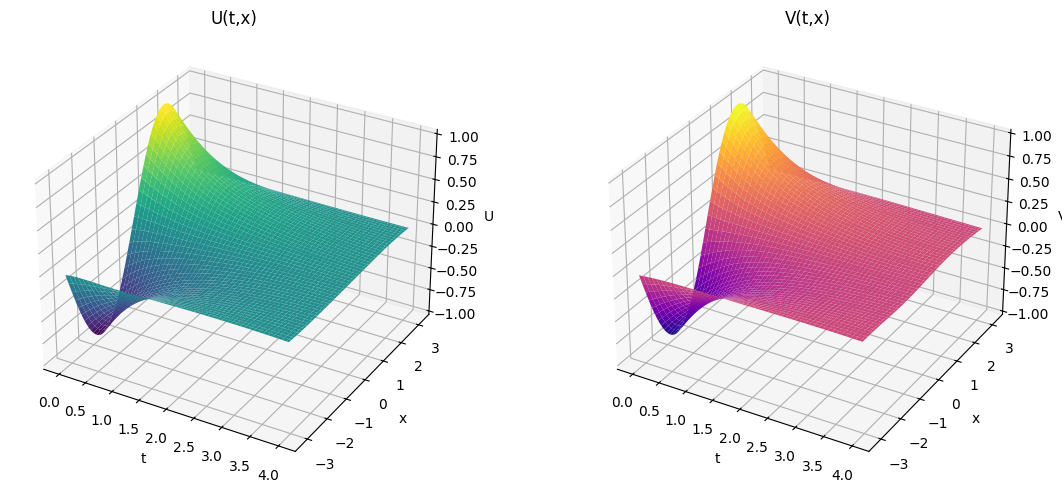

In [9]:
# Recompute the prediction safely
with torch.no_grad():
    prediction = model(TX)
    u_pred, v_pred = prediction[0], prediction[1]
    U = u_pred.reshape(N_plot, N_plot).cpu().numpy()
    V = v_pred.reshape(N_plot, N_plot).cpu().numpy()

T_np = T.cpu().numpy()
X_np = X.cpu().numpy()

# Plot U and V using surface plots
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(T_np, X_np, U, cmap='viridis')
ax1.set_title("U(t,x)")
ax1.set_xlabel('t')
ax1.set_ylabel('x')
ax1.set_zlabel('U')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(T_np, X_np, V, cmap='plasma')
ax2.set_title("V(t,x)")
ax2.set_xlabel('t')
ax2.set_ylabel('x')
ax2.set_zlabel('V')

plt.tight_layout()
plt.show()


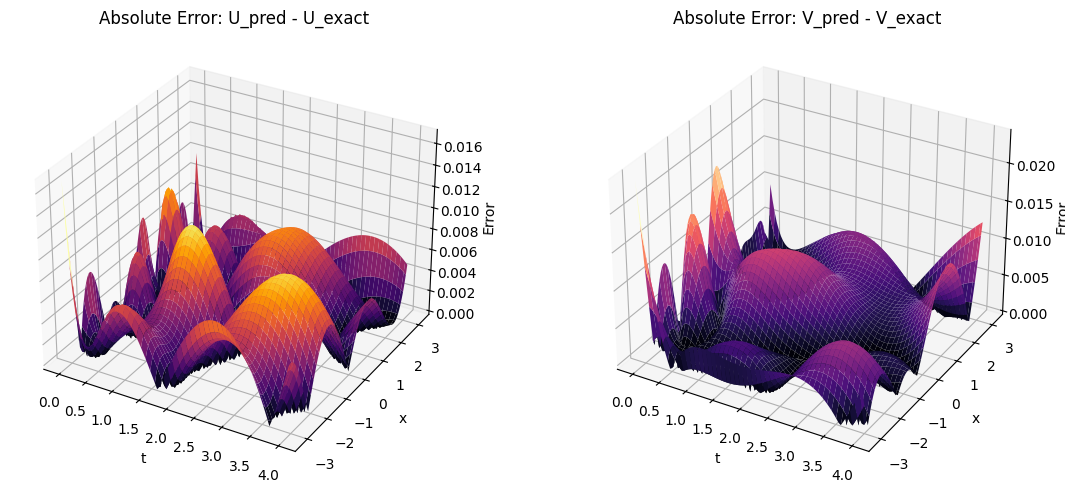

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Convert tensors to NumPy if not already done
T_np = T.cpu().numpy()
X_np = X.cpu().numpy()

# Compute exact solution
U_exact = np.exp(-T_np) * np.sin(X_np)
V_exact = np.exp(-T_np) * np.sin(X_np)

# Compute absolute error
U_error = np.abs(U - U_exact)
V_error = np.abs(V - V_exact)

# Plot error surface for U
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(T_np, X_np, U_error, cmap='inferno')
ax1.set_title("Absolute Error: U_pred - U_exact")
ax1.set_xlabel('t')
ax1.set_ylabel('x')
ax1.set_zlabel('Error')

# Plot error surface for V
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(T_np, X_np, V_error, cmap='magma')
ax2.set_title("Absolute Error: V_pred - V_exact")
ax2.set_xlabel('t')
ax2.set_ylabel('x')
ax2.set_zlabel('Error')

plt.tight_layout()
plt.show()


In [11]:
from sklearn.metrics import mean_squared_error

# Flatten the arrays for MSE computation
U_flat = U.flatten()
V_flat = V.flatten()
U_exact_flat = U_exact.flatten()
V_exact_flat = V_exact.flatten()

# Compute MSE
mse_U = mean_squared_error(U_exact_flat, U_flat)
mse_V = mean_squared_error(V_exact_flat, V_flat)

print(f"Mean Squared Error for U: {mse_U:.6e}")
print(f"Mean Squared Error for V: {mse_V:.6e}")


Mean Squared Error for U: 2.286849e-05
Mean Squared Error for V: 2.261282e-05


In [12]:
# Convert to flat arrays
U_flat = U.flatten()
V_flat = V.flatten()
U_exact_flat = U_exact.flatten()
V_exact_flat = V_exact.flatten()

# L-infinity error (max absolute error)
Linf_U = np.max(np.abs(U_flat - U_exact_flat))
Linf_V = np.max(np.abs(V_flat - V_exact_flat))

# L2 error (root mean squared error)
L2_U = np.sqrt(np.mean((U_flat - U_exact_flat) ** 2))
L2_V = np.sqrt(np.mean((V_flat - V_exact_flat) ** 2))

print(f"L-infinity Error for U: {Linf_U:.6e}")
print(f"L2 Error for U:         {L2_U:.6e}")
print(f"L-infinity Error for V: {Linf_V:.6e}")
print(f"L2 Error for V:         {L2_V:.6e}")


L-infinity Error for U: 1.694113e-02
L2 Error for U:         4.782101e-03
L-infinity Error for V: 2.386546e-02
L2 Error for V:         4.755294e-03


In [1]:
def compare_pinn_vs_exact(model, t_values=[0.5,1,1.5, 2,2.5, 3,3.5, 4], N_x=200):
    import matplotlib.pyplot as plt

    x = torch.linspace(xmin, xmax, N_x, device=device)
    
    fig_u, axes_u = plt.subplots(1, len(t_values), figsize=(20, 4))
    fig_v, axes_v = plt.subplots(1, len(t_values), figsize=(20, 4))

    for i, t_val in enumerate(t_values):
        t = torch.full_like(x, float(t_val))
        X = torch.stack([t, x], dim=1)

        with torch.no_grad():
            u_pred, v_pred = model(X)
        u_true = exact_solution(x, t)
        v_true = exact_solution(x, t)

        # Plot for u(x,t)
        axes_u[i].plot(x.cpu(), u_true.cpu(), 'k-', label='Exact u', linewidth=2)
        axes_u[i].plot(x.cpu(), u_pred.cpu(), 'r--', label='Predicted u', linewidth=1.5)
        axes_u[i].set_title(f"u(x, t={t_val})")
        axes_u[i].legend()
        axes_u[i].grid(True)

        # Plot for v(x,t)
        axes_v[i].plot(x.cpu(), v_true.cpu(), 'k-', label='Exact v', linewidth=2)
        axes_v[i].plot(x.cpu(), v_pred.cpu(), 'b--', label='Predicted v', linewidth=1.5)
        axes_v[i].set_title(f"v(x, t={t_val})")
        axes_v[i].legend()
        axes_v[i].grid(True)

    fig_u.suptitle("Comparison of u(x,t): Exact vs. PINN", fontsize=16)
    fig_v.suptitle("Comparison of v(x,t): Exact vs. PINN", fontsize=16)

    fig_u.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig_v.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [2]:
compare_pinn_vs_exact(model)

NameError: name 'model' is not defined

In [19]:
def compare_pinn_vs_exact(model, t_values=[1, 2, 3, 4, 5], N_x=200):
    import matplotlib.pyplot as plt

    x = torch.linspace(xmin, xmax, N_x, device=device)

    # Setup one figure for u and one for v
    fig_u, ax_u = plt.subplots(figsize=(10, 5))
    fig_v, ax_v = plt.subplots(figsize=(10, 5))

    colors = ['r', 'g', 'b', 'c', 'm']

    for i, t_val in enumerate(t_values):
        t = torch.full_like(x, float(t_val))
        X = torch.stack([t, x], dim=1)

        with torch.no_grad():
            u_pred, v_pred = model(X)
        u_true = exact_solution(x, t)
        v_true = exact_solution(x, t)

        # Plot both predicted and exact u(x,t)
        ax_u.plot(x.cpu(), u_true.cpu(), color=colors[i], linestyle='-', label=f'Exact u, t={t_val}')
        ax_u.plot(x.cpu(), u_pred.cpu(), color=colors[i], linestyle='--', label=f'Predicted u, t={t_val}')

        # Plot both predicted and exact v(x,t)
        ax_v.plot(x.cpu(), v_true.cpu(), color=colors[i], linestyle='-', label=f'Exact v, t={t_val}')
        ax_v.plot(x.cpu(), v_pred.cpu(), color=colors[i], linestyle='--', label=f'Predicted v, t={t_val}')

    ax_u.set_title("u(x,t): Exact vs PINN")
    ax_u.set_xlabel("x")
    ax_u.set_ylabel("u")
    ax_u.grid(True)
    ax_u.legend()

    ax_v.set_title("v(x,t): Exact vs PINN")
    ax_v.set_xlabel("x")
    ax_v.set_ylabel("v")
    ax_v.grid(True)
    ax_v.legend()

    plt.tight_layout()
    plt.show()


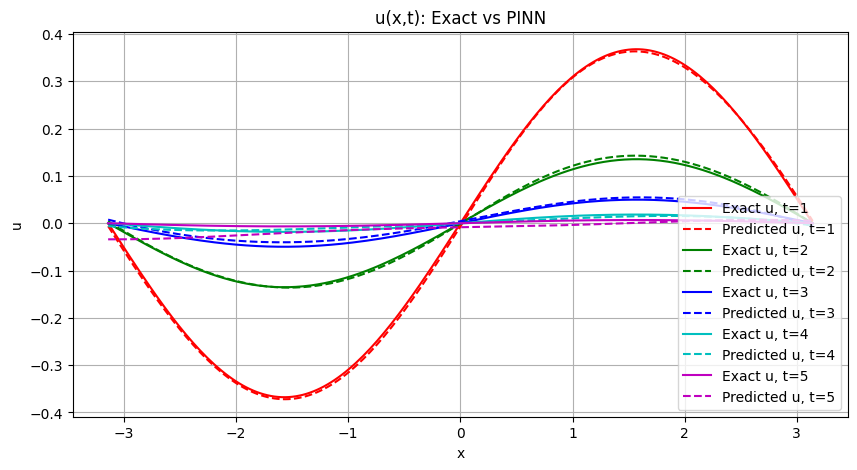

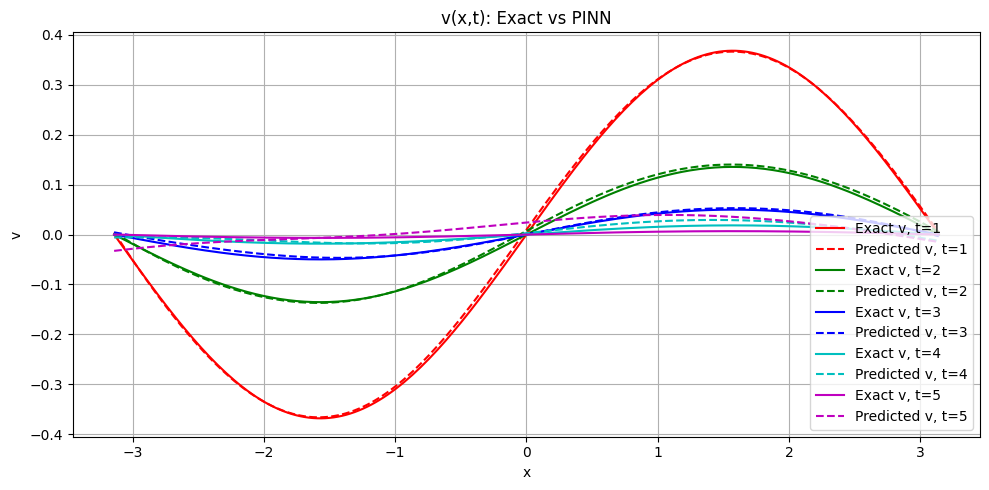

In [20]:
compare_pinn_vs_exact(model)